In [64]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

In [65]:
#导入数据
y_label = 'y3_label'
raw_data_path = '/home/laiminzhi/data/xydata/'
xydata = pd.read_hdf(raw_data_path+'xy_data_2836.h5')
xydata.index = xydata.index.set_names(['code1','date','code'], level=[0, 1,2])
# 删除不需要的索引层
xydata = xydata.droplevel('code1')

xydata_limit = pd.read_hdf(raw_data_path+'xy_data_2836_udlimit.h5')
#selected_feature = pd.read_csv('selected_feature.csv',index_col=0)['AlphaName'].to_list()
selected_feature = xydata.columns[xydata.columns.str.startswith('x')].to_list()
xydata = xydata.loc[:,[y_label]+selected_feature]
# 把xydata_limit的ud_limit_h2列加到xydata中
xydata = xydata.join(xydata_limit['ud_limit_h2'])
xydata_final = xydata[xydata['ud_limit_h2']!=1]

#除去inf
xydata_final = xydata_final.replace([np.inf, -np.inf], 0.0)

In [66]:
xydata_final = xydata_final.drop(columns='ud_limit_h2')

In [5]:
def rank_cross_profile(df):
    result_df = pd.DataFrame(index=df.index,columns=df.columns)
    unique_dates = df.index.get_level_values('date').unique()
    for date in unique_dates:
        date_data = df[df.index.get_level_values('date') == date]

        # 对截面上的数据进行排序
        ranked_date_data = date_data.rank(axis=0)
        mean = ranked_date_data.mean(axis=0)
        normalize_ranked_date_data = (ranked_date_data-mean)
        result_df.loc[result_df.index.get_level_values('date') == date] = normalize_ranked_date_data

    return result_df

In [67]:
xydata_final = xydata_final.sort_index(level='date')
train = xydata_final.loc[:'20211231',]
test = xydata_final.loc['20220104':,]

y_train = train[y_label].values
y_test = test[y_label].values

#train = rank_cross_profile(train)
#test = rank_cross_profile(test)

#scalar = MinMaxScaler()
X_train = train.drop(y_label,axis=1).values

#X_train = scalar.fit_transform(X_train)

X_test = test.drop(y_label,axis=1).values
#X_test = scalar.transform(X_test)




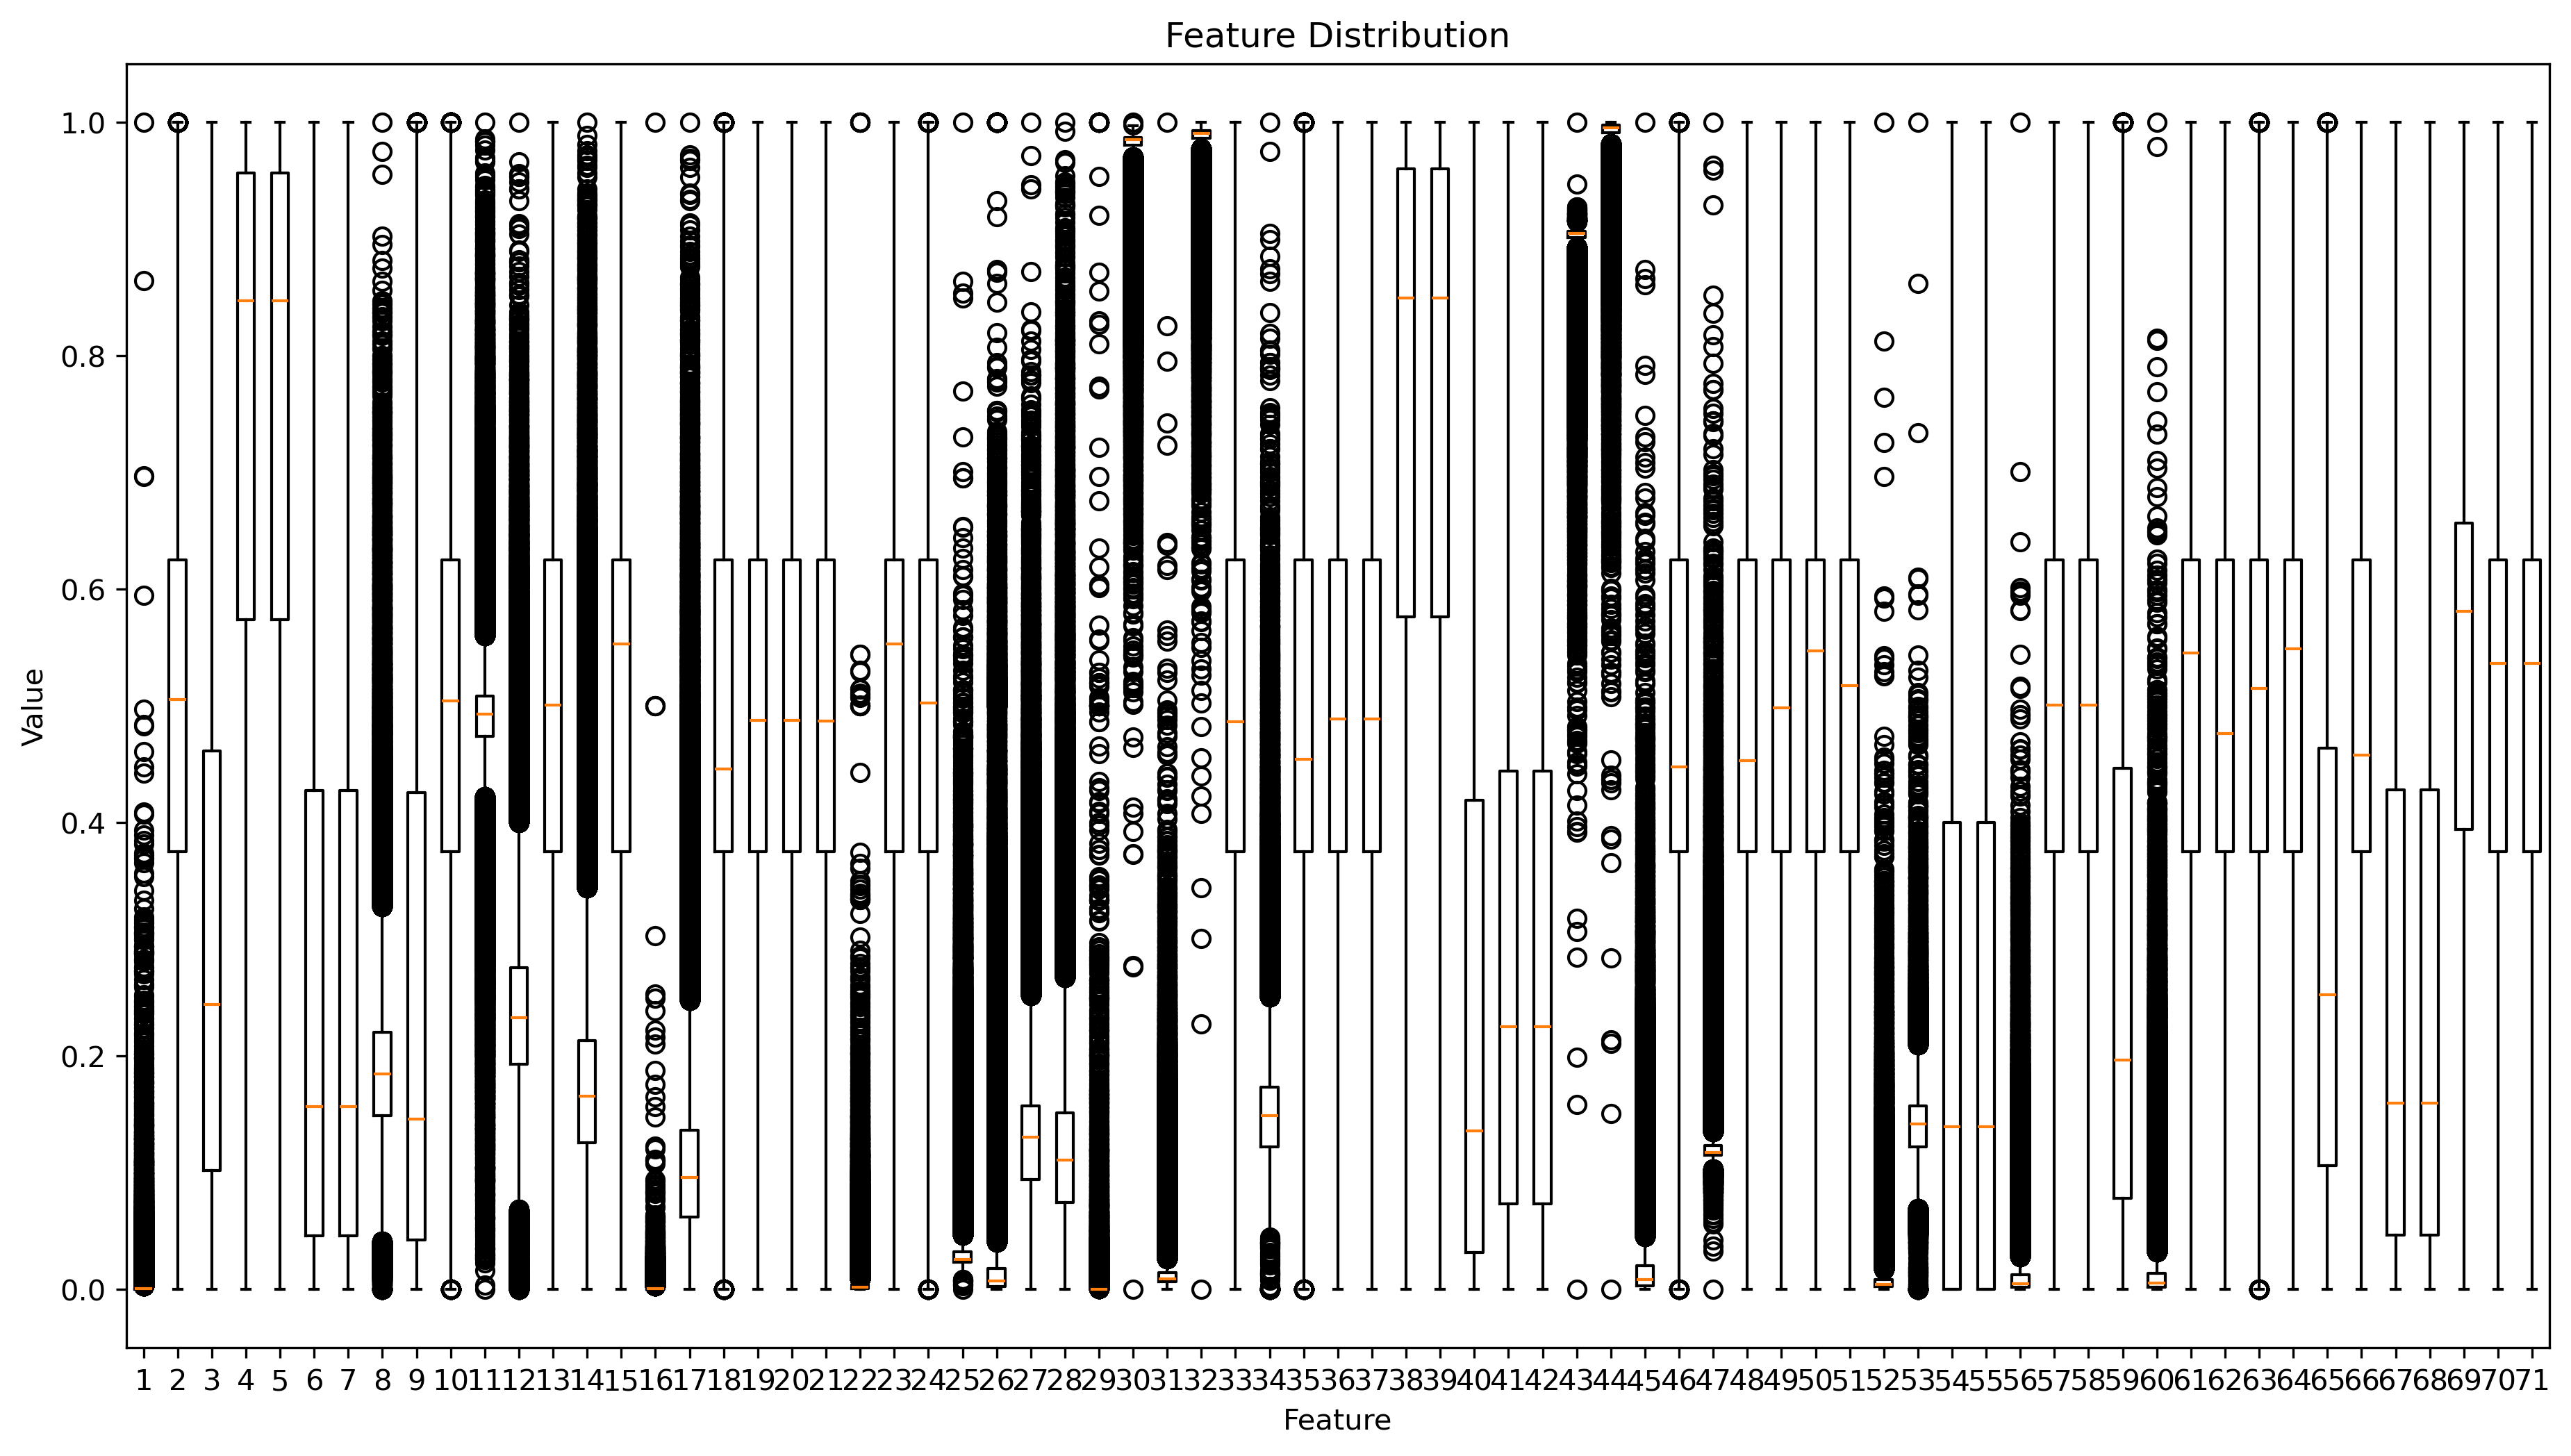

In [56]:
#查看不同feature的箱线图
def fit_remove_outliers(df,columns):
    #用来在训练集上去除极端值，记录上下界
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        df.loc[:,col] = df[col].clip(lower_limit, upper_limit)

    return df

#train_plot = fit_remove_outliers(train,train.columns)
#train_plot.boxplot(column=selected_feature,figsize=(20,10))
train_plot = X_train
import matplotlib.pyplot as plt
# 绘制箱线图
plt.figure(dpi=300, figsize=(15, 8))
plt.boxplot(train_plot)

# 设置图表标题和轴标签
plt.title('Feature Distribution')
plt.xlabel('Feature')
plt.ylabel('Value')


# 显示图表
plt.show()


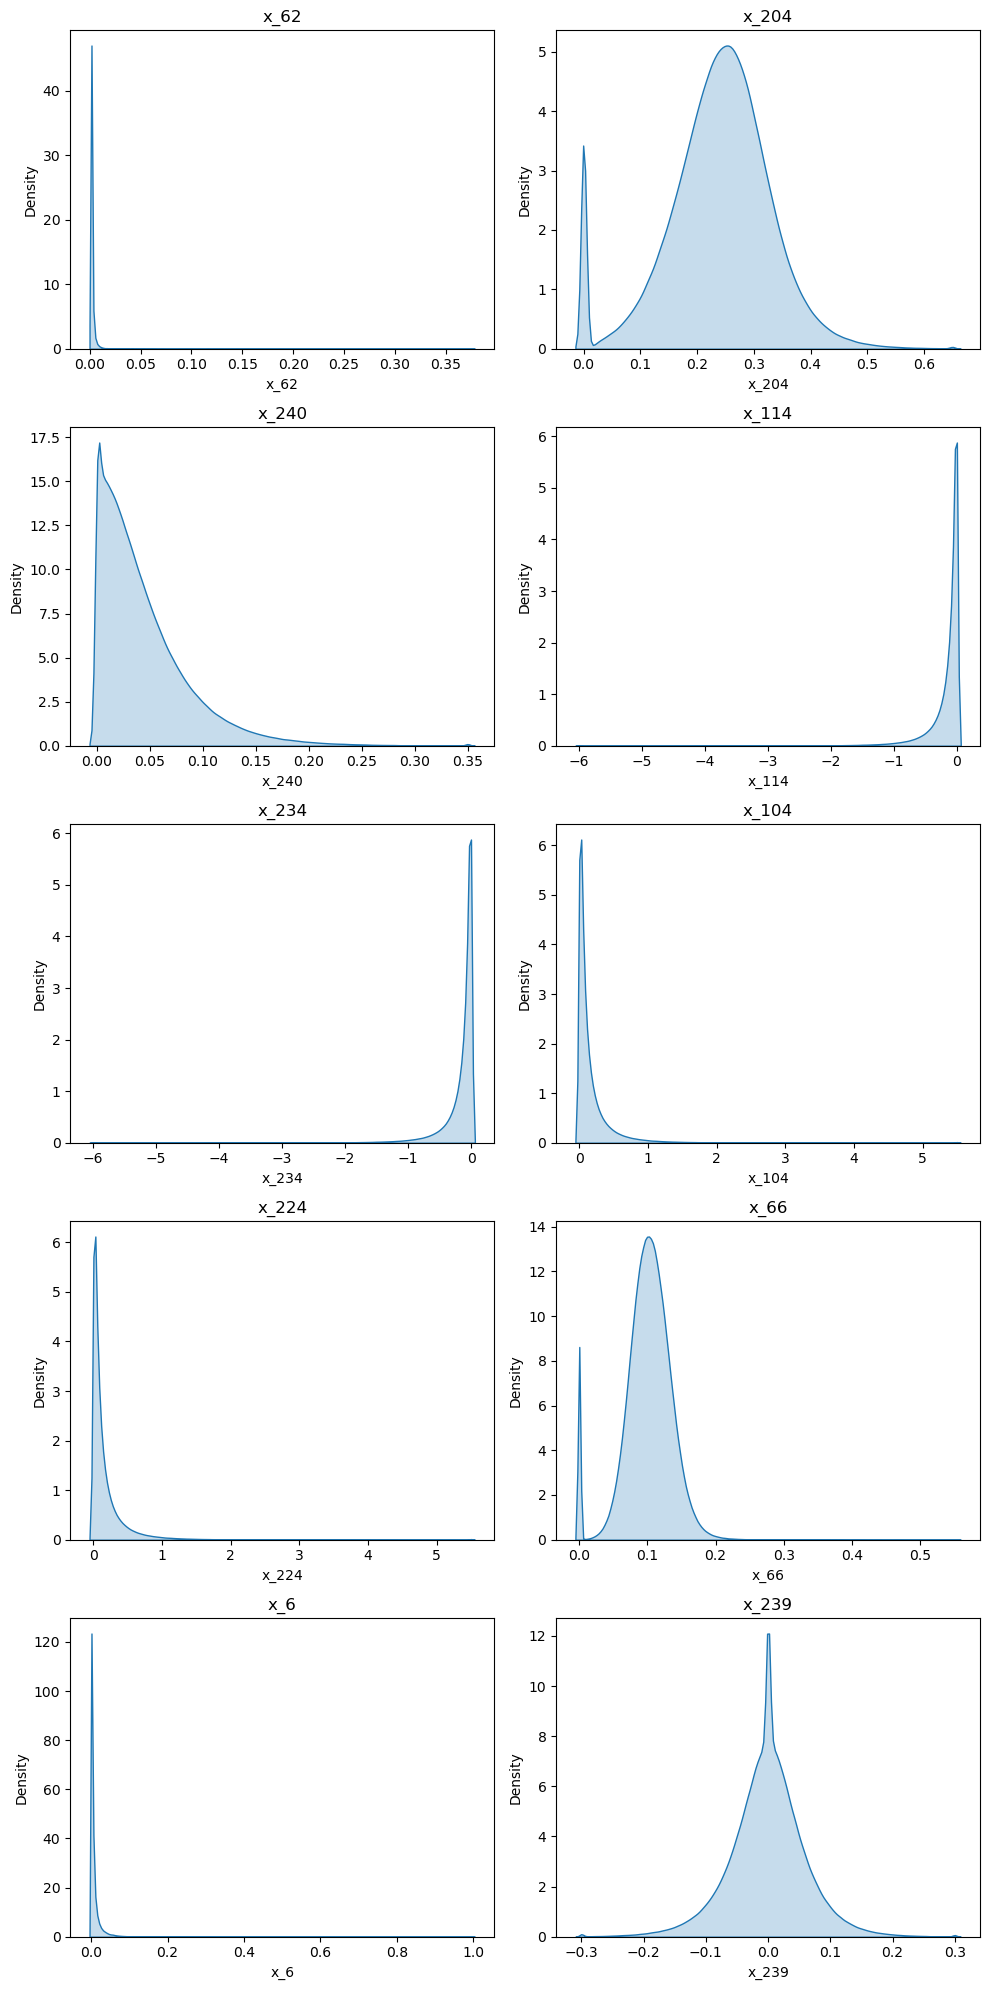

In [77]:
#查看feature的分布
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# 忽略特定的 FutureWarning
warnings.filterwarnings('ignore', category=FutureWarning, message="use_inf_as_na option is deprecated")

selected_feature = pd.read_csv('selected_feature.csv',index_col=0)['AlphaName'].to_list()
columns_to_plot = selected_feature[0:10]  # 选择前10列
num_plots = len(columns_to_plot)
num_cols = 2  # 一行显示 2 个图
num_rows = num_plots // num_cols + (num_plots % num_cols > 0)

plt.figure(figsize=(10, num_rows * 4))

for i, col in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(train[col], fill=True)
    plt.title(col)

plt.tight_layout()

In [68]:
# 定义一系列 alpha 值
alphas = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]

# 初始化 RidgeCV
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# 拟合模型
ridge_cv.fit(X_train, y_train)

# 最优的 alpha
print('Chosen alpha:', ridge_cv.alpha_)

# 使用最优的 alpha 进行预测
y_pred = ridge_cv.predict(X_test)

# 查看交叉验证的结果
print('Mean squared errors for each alpha:', np.mean(ridge_cv.cv_values_, axis=0))

Chosen alpha: 0.9
Mean squared errors for each alpha: [0.11740989 0.14618323 0.10884673 0.12092602 0.09675645 0.12296013
 0.10264145 0.15365595 0.09741258 0.11472741 0.10081236]


In [69]:
#查看ridgeCV的系数
print('RidgeCV coefficients:', ridge_cv.coef_)

RidgeCV coefficients: [-4.76191531e-08  1.95004311e-01 -1.97173187e-02 -2.34612816e-03
 -5.10212861e-02 -1.59664033e-02 -2.21682112e-02  1.27861955e-01
  1.03638020e-02 -2.98510470e-01  4.00098375e-01  5.73351576e-03
  1.52861813e-03  2.02745158e-03  4.55959834e-03  9.63401934e-03
 -6.36583053e-03 -6.40609898e-03  5.16022841e-03  7.48097445e-03
 -2.27179399e-02 -4.82239355e-02  2.85206933e-03 -8.67518154e-04
  4.92533933e-03  1.48663650e-02 -2.26308200e-02 -2.57682192e-02
  4.70868001e-03  9.61618997e-03  1.21857762e-02  5.55783408e-05
  3.01688614e-03  1.03556438e-02 -4.40338135e-01 -8.40225122e-04
  4.46408831e-03  1.29799808e-02  3.71143341e+00  8.36369014e-03
 -8.47300031e-04  1.74125002e-03  1.22238770e+02  2.04425400e-03
 -2.02181236e-05 -3.52794940e-03  1.82839966e+01  4.78658747e-03
 -1.18730938e-03  1.81672081e-03 -1.38246846e-02 -5.48443158e-04
 -2.70833833e-03  4.46052755e-03 -1.37152786e-02 -1.55179746e-04
 -2.50547776e-02 -7.80418186e-04  1.21920193e-03 -3.41185616e-02
 -1

In [70]:
from scipy.stats import spearmanr
def calculate_spearman(group):
    return spearmanr(group['Y_hat'], group['Y'])[0]

In [71]:
#把y_label和y_test还原回dataframe
y_test_df = pd.DataFrame(y_test, index=test.index, columns=['Y'])
y_pred_df = pd.DataFrame(y_pred, index=test.index, columns=['Y_hat'])
result = pd.concat([y_test_df,y_pred_df],axis=1)
#计算result的rank ic
spearman_correlations = result.groupby(level='date').apply(calculate_spearman)
rank_avg = spearman_correlations.mean()


In [72]:
print('rank_avg:',rank_avg) 
grouped_df = result.groupby(level='date')
    
for name,group in grouped_df:
    group = group.reset_index(drop=False)
    group.to_csv('./ridgeCV/'+name+'.csv')
print("data saved!")

rank_avg: -0.012733420239610282
data saved!


In [74]:
def cal_alpha(XY):
    #查看pnl如何计算
    d1 = XY.copy()
    enterRatio = 0.9
    exitRatio = 0.9
    ## 1) calculate yestRank;
    d1['yestRank'] = d1.groupby('date')['yest'].rank(method='average',na_option='keep',ascending=True,pct=True)
    rtnMat = pd.pivot_table(data=d1,index='date',columns='code',values='y',dropna=False)
    yestMat = pd.pivot_table(data=d1,index='date',columns='code',values='yest',dropna=False)
    yestRankMat = pd.pivot_table(data=d1,index='date',columns='code',values='yestRank',dropna=False).fillna(0)
    posiMat = pd.DataFrame(np.full(yestRankMat.shape,fill_value=0),index=yestRankMat.index,columns=yestRankMat.columns)
    ud_limitMat = pd.pivot_table(data=d1,index='date',columns='code',values='ud_limit_h2',dropna=False).fillna(0)

    ## 2) calPosiMat： ## no buy if up_limit && no sell if down_limit;
    for i,row_index in enumerate(posiMat.index):
        if (i==0):
            continue
        flag1 = (yestRankMat.iloc[i,:]>enterRatio)
        flag2 = (posiMat.iloc[i-1,:]==0) & (ud_limitMat.iloc[i,:]==1)
        posiMat.loc[row_index,(~flag2 & flag1)] = 1

        flag3 = (yestRankMat.iloc[i,:]>exitRatio) & (yestRankMat.iloc[i,:]<=enterRatio)
        flag4 = (posiMat.iloc[i-1,:]==1)
        posiMat.loc[row_index,(flag3 & flag4)] = 1

        flag5 = (posiMat.iloc[i-1,:]==1) & (posiMat.iloc[i,:]==0) & (ud_limitMat.iloc[i,:]==-1)
        posiMat.loc[row_index,flag5] = 1
        
        if (i== (posiMat.shape[0]-1)):## position=0 if yest=NA on last day;
            flag6 = yestMat.iloc[i,:].isna()
            posiMat.loc[row_index,flag6] = 0


    pnlMat = rtnMat * posiMat
    pnlVec = pnlMat.sum(axis=1)/(posiMat==1).sum(axis=1)
    alpha = pnlVec.mean()*1e4
    return alpha

def get_XY(yest,xy):
    #xy是原始xy文件，yest是合并后的预测文件
    universe = 'univ_tradable'

    XY = xy.loc[xy[universe]==1,:'ud_limit_h4']
    XY= XY.rename(columns={'y1':'y'})
    XY = pd.merge(XY, yest,on=['date','code'],how='inner')

    ##---- 1. benchmark ----##
    XY['yest'] = XY['Y_hat']
    return XY


In [75]:
import os
xy = pd.read_hdf("/home/laiminzhi/wenbin/DL_stock_combo/data/xy_data/xy_data_new.h5")
all_files = [pd.read_csv(f'./ridgeCV/{f}',
                            dtype={'date':str})for f in sorted(os.listdir('./ridgeCV'))]
yest = pd.concat(all_files, axis=0) #贴合所有的预测值
XY = get_XY(yest,xy)
alpha = cal_alpha(XY)
print('alpha:',alpha)


alpha: -5.244877101848944
